In [23]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import pandas as pd
import pylab as pl
import random
import importer
from total import Tag,count,type_list,type_total,Inverse_Transform_Sampling
from mcs_of_charging_Start_time import R_cst_list,R_cst
from mcs_charging_amount_n_charging_span import cs_list,cs,CP
from model_of_charing_mode import scm_list,scm

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号 

### 1. 获取充电开始时间和结束时间的列表
为便于统计各个时间的充电总功率，对结束时间列表进行特殊处理：
1. 新建一个最后一小时充电时长列表，用于存放最后一个小时的具体充电时长
2. 结束时间列表向下进行取整

In [24]:
ct_start,ct_start_list=R_cst,R_cst_list#充电开始时间
ct_end,ct_end_list=[],[[],[],[],[]]#充电结束时间
#得到充电最后一小时的具体时长
lc_end,lc_end_list=cs-np.floor(cs),[[],[],[],[]]
for i in range(0,4):
        lc_end_list[i]=(cs_list[i]-np.floor(cs_list[i]))

In [25]:
for i in range(0,len(ct_start)):
        ct_end.append(math.floor(ct_start[i]+cs[i]))

for k in range(0,4):
        for i in range(0,len(ct_start_list[k])):
                ct_end_list[k].append(math.floor(ct_start_list[k][i]+cs_list[k][i]))



### 2. 计算每个小时的充电总功率
创建一个长度为48的空列表，利用hashmap进行对count个样本在各个时间段的充电功率进行累加统计，思想如下：
1. 用充电开始时间-充电结束时间，足1小时的则耗电充电功率，不足1小时的则用充电最后一小时时长*充电功率
2. 考虑到凌晨充电的行为，将48小时进行对折成24小时


In [26]:
pc_sum=[]
hashmap=np.zeros(48)
for i in range(0,count):
    for j in range(ct_start[i],ct_end[i]):
        hashmap[j]+=CP[int(scm[i])][int(type_total[i])]
    hashmap[ct_end[i]]+=lc_end[i]*CP[int(scm[i])][int(type_total[i])]

for i in range(0,24):#两个24小时对折相加
    pc_sum.append(hashmap[i]+hashmap[i+24])

pc_sum_list=[[],[],[],[]]
for k in range(0,4):
    hashmap=np.zeros(48)
    for i in range(0,len(ct_start_list[k])):
        for j in range(ct_start_list[k][i],ct_end_list[k][i]):
            hashmap[j]+=CP[int(scm_list[k][i])][k]
        hashmap[ct_end_list[k][i]]+=lc_end_list[k][i]*CP[int(scm_list[k][i])][k]
    for i in range(0,24):#两个24小时对折相加
        pc_sum_list[k].append(hashmap[i] + hashmap[i+24])



### 3. 日充电功率变化曲线

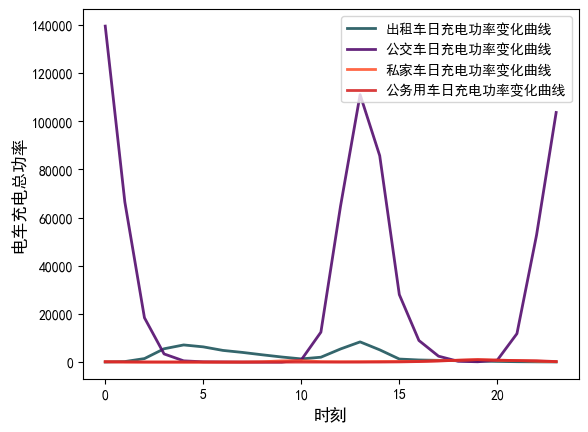

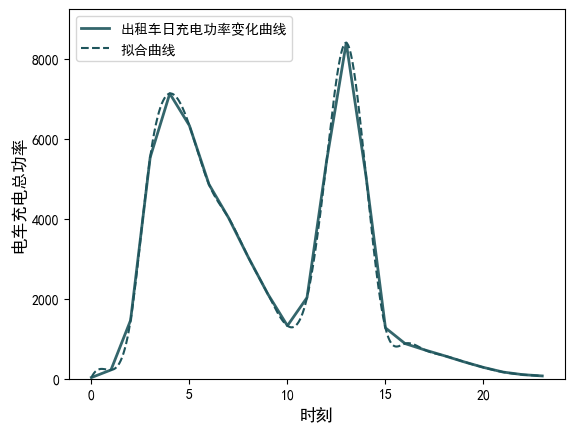

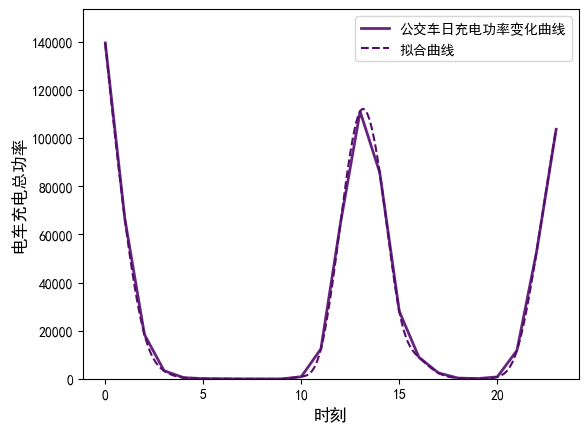

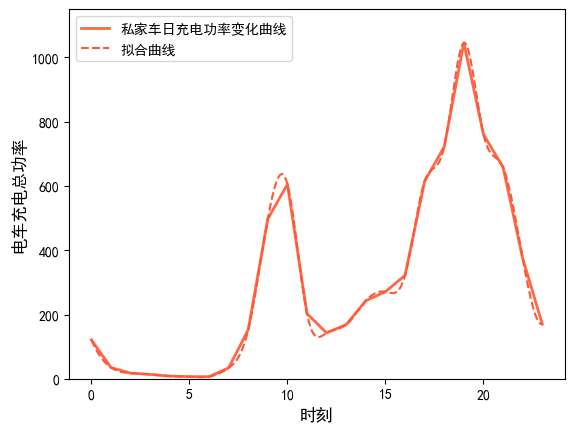

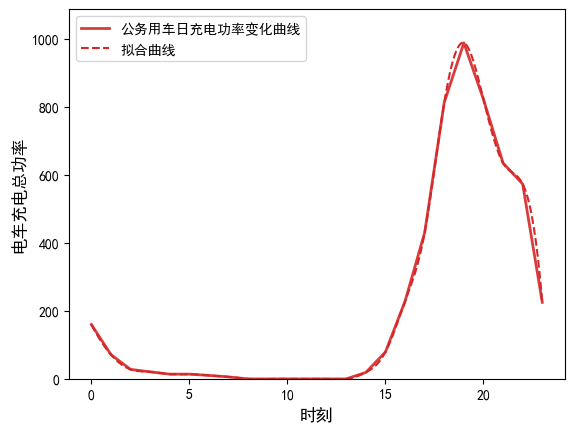

In [27]:
line_color=['#1E555C','#540D6E','#FF5733','#d62728']
for i in range(0,4):
    x=range(0,24)
    plt.plot(x,pc_sum_list[i],line_color[i],linewidth=2, alpha=0.9,label="{}日充电功率变化曲线".format(Tag[i]))
    plt.xlabel("时刻", fontsize=12)
    plt.ylabel("电车充电总功率", fontsize=12)
    plt.legend(prop={'size': 10})
plt.show()




line_color=['#1E555C','#540D6E','#FF5733','#d62728']
for i in range(0,4):
    x=range(0,24)
    plt.plot(x,pc_sum_list[i],line_color[i],linewidth=2, alpha=0.9,label="{}日充电功率变化曲线".format(Tag[i]))

    xnew=np.linspace(0,23,1000)
    f=interpolate.interp1d(x,pc_sum_list[i],'cubic')#3阶插值
    ynew=f(xnew)
    plt.plot(xnew,ynew,color=line_color[i],linewidth=1.5,linestyle="--",label='拟合曲线')
    plt.xlabel("时刻", fontsize=12)
    plt.ylabel("电车充电总功率", fontsize=12)
    plt.ylim(0,max(pc_sum_list[i])*1.1)
    plt.legend(prop={'size': 10})
    plt.show()

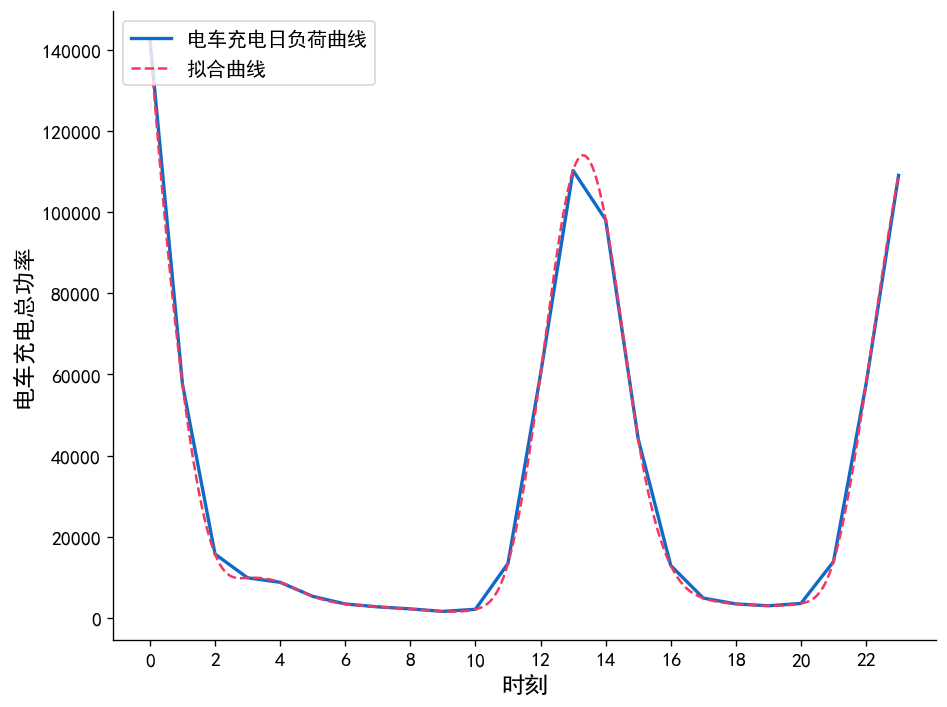

In [28]:
x = range(0, 24)
fig, ax = plt.subplots(figsize=(8, 6), dpi=120)
ax.plot(x, pc_sum, '#0E6AC7', linewidth=2, label="电车充电日负荷曲线")
xnew = np.linspace(0, 23, 1000)
f = interpolate.interp1d(x, pc_sum, 'cubic')  # 3阶插值
ynew = f(xnew)
ax.plot(xnew, ynew, '#F03861', linewidth=1.5, linestyle="--", label="拟合曲线")
ax.set_xlabel("时刻", fontsize=14)
ax.set_ylabel("电车充电总功率", fontsize=14)
ax.legend(loc='upper left', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(0, 24, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## 4. 日负荷峰值与其峰值时间

In [29]:
power_max_list,power_max_time_list=[],[]
for i in range(4):
    power_max = max(pc_sum_list[i])
    power_max_time = np.argmax(pc_sum_list[i])
    power_max_list.append(power_max)
    power_max_time_list.append(power_max_time)

data = {'电车类型': Tag,
        '充电最大负荷(kW)': [f'{p:.2f}' for p in power_max_list],
        '峰值时间(时)': [f'{t}' for t in power_max_time_list]}
df = pd.DataFrame(data)
print(df)

power_max,power_max_time=max(pc_sum),np.argmax(pc_sum)
pc_sum.remove(power_max)
secondary_power_max,secondary_power_max_time=max(pc_sum),np.argmax(pc_sum)+1
print("\n该区域电车充电最大负荷为{:.2f}kw,其峰值时间为{}点；次峰值负荷为{:.2f}kw,其时间为{}点；日累积充电负荷为{:.2f}kw".format(power_max,power_max_time,secondary_power_max,secondary_power_max_time,sum(pc_sum)))


   电车类型 充电最大负荷(kW) 峰值时间(时)
0   出租车    8395.00      13
1   公交车  139528.20       0
2   私家车    1045.25      19
3  公务用车     988.45      19

该区域电车充电最大负荷为142511.85kw,其峰值时间为0点；次峰值负荷为110251.11kw,其时间为13点；日累积充电负荷为643822.64kw
